#### Import the ipyparallel module and connect to the clusters

In [1]:
import ipyparallel as ipp
client = ipp.Client()
lview  = client.load_balanced_view()
lview.block = True
CORES = len(client[:])
for i in range(0,CORES):
    client[i].push(dict(i=i))

#### Import pandas and numpy, both locally and on the clusters

In [2]:
%%px --local
import pandas as pd
import numpy  as np

#### Import some data from a csv file

In [5]:
%%time
raw = pd.read_csv('Stocks.zip', parse_dates=['date'], compression='zip')

Wall time: 3.67 s


Let's have a look:

In [6]:
raw.head()

,Unnamed: 0,stock,date,close,turnover,cap
0,0,9983.T,2014-11-20,42845.0,4456.322944,4544740.53
1,1,9983.T,2015-07-29,60230.0,5275.562343,6388837.02
2,2,9983.T,2015-03-02,46850.0,4675.038181,4969566.90
3,3,9983.T,2013-08-19,32200.0,3325.979976,3415582.80
4,4,9983.T,2015-02-12,44305.0,4761.770085,4699608.57


#### We want to get rid of the first column:

In [224]:
stocks = raw[ ['stock', 'date', 'close', 'turnover', 'cap'] ]
stocks.head()

,stock,date,close,turnover,cap
0,9983.T,2014-11-20,42845.0,4456.322944,4544740.53
1,9983.T,2015-07-29,60230.0,5275.562343,6388837.02
2,9983.T,2015-03-02,46850.0,4675.038181,4969566.90
3,9983.T,2013-08-19,32200.0,3325.979976,3415582.80
4,9983.T,2015-02-12,44305.0,4761.770085,4699608.57


#### Equivalently we could do

In [225]:
stocks = raw[ raw.columns[1:] ]
stocks.head()

,stock,date,close,turnover,cap
0,9983.T,2014-11-20,42845.0,4456.322944,4544740.53
1,9983.T,2015-07-29,60230.0,5275.562343,6388837.02
2,9983.T,2015-03-02,46850.0,4675.038181,4969566.90
3,9983.T,2013-08-19,32200.0,3325.979976,3415582.80
4,9983.T,2015-02-12,44305.0,4761.770085,4699608.57


#### Or also

In [226]:
stocks = raw.drop( 'Unnamed: 0', axis=1 )
stocks.head()

,stock,date,close,turnover,cap
0,9983.T,2014-11-20,42845.0,4456.322944,4544740.53
1,9983.T,2015-07-29,60230.0,5275.562343,6388837.02
2,9983.T,2015-03-02,46850.0,4675.038181,4969566.90
3,9983.T,2013-08-19,32200.0,3325.979976,3415582.80
4,9983.T,2015-02-12,44305.0,4761.770085,4699608.57


#### Let's keep only business days

In [227]:
business_days = pd.bdate_range( stocks['date'].min(), stocks['date'].max() )
stocks = stocks[ stocks['date'].isin( business_days ) ]

<br/><br/><br/><br/>

# Data aggregation

#### We can aggregate the data by stock with the *groupby* command

In [228]:
avg_cap = stocks.groupby('stock')[['cap']].mean()
avg_cap.head()

,cap
stock,
1301.T,28608.728214
1332.T,95012.344141
1333.T,100042.026033
1352.T,10761.203478
1376.T,11882.820396


<div class='alert alert-info'> Notice that the resulting dataframe is indexed by *stock* </div>

#### We can also aggregate multiple variables at once

In [229]:
avg = stocks.groupby('stock')[['cap', 'turnover']].mean()
avg.head()

,cap,turnover
stock,,
1301.T,28608.728214,7943.031416
1332.T,95012.344141,11100.306478
1333.T,100042.026033,4514.926094
1352.T,10761.203478,2012.388261
1376.T,11882.820396,1360.017895


<div class='alert alert-warning'>Careful with the number of parenthesis: you can get a pandas dataframe or a pandas series </div>

In [230]:
df = stocks.groupby('stock')[['cap']].std()    # DataFrame
se = stocks.groupby('stock')['cap'].std()      # Series
se.head()

stock
1301.T     2149.388053
1332.T    36982.146276
1333.T    20620.263839
1352.T      891.328046
1376.T     1976.537494
Name: cap, dtype: float64

<br/><br/><br/><br/>

# Scattering data on the clusters

In [231]:
client[:].scatter( 'stocks', stocks )

<AsyncResult: scatter>

In [232]:
%%px --target :2
stocks.head()

,stock,date,close,turnover,cap
0,9983.T,2014-11-20,42845.0,4456.322944,4544740.53
1,9983.T,2015-07-29,60230.0,5275.562343,6388837.02
2,9983.T,2015-03-02,46850.0,4675.038181,4969566.90
3,9983.T,2013-08-19,32200.0,3325.979976,3415582.80
4,9983.T,2015-02-12,44305.0,4761.770085,4699608.57


,stock,date,close,turnover,cap
77294,5713.T,2014-12-01,1739.5,14349.377953,1011741.906
77295,8031.T,2016-04-04,1268.0,5368.563785,2277979.752
77296,5713.T,2015-11-27,1412.0,13732.144945,821258.736
77297,8031.T,2013-04-02,1258.0,8052.196836,2301074.474
77298,8031.T,2014-07-10,1631.0,4161.837870,2930114.334


### Often you would like the data to be splitted by groups ( for instance by stocks in our case ). Let's do it!

#### First we create an array with the tickers

In [233]:
tickers = np.unique( stocks['stock'] )
tickers

array(['1301.T', '1332.T', '1333.T', ..., '9994.T', '9995.T', '9997.T'], dtype=object)

#### And we scatter that around

In [234]:
client[:].scatter( 'tickers', tickers )

<AsyncResult: scatter>

#### Now every cluster contains some tickers

In [235]:
%%px --target :2
tickers[:5]

Out[0:122]: array(['1301.T', '1332.T', '1333.T', '1352.T', '1376.T'], dtype=object)

Out[1:62]: array(['1929.T', '1930.T', '1934.T', '1937.T', '1939.T'], dtype=object)

#### Ok, now let's send the data

In [236]:
for i in range(CORES):
    cluster_tickers = client[i].pull( 'tickers' ).get()
    cluster_stocks  = stocks[ stocks['stock'].isin( cluster_tickers ) ]
    client[i].push( { 'stocks': cluster_stocks } )

#### Cool! Now every cluster has some stocks

In [237]:
%%px --target :2
stocks.head(2)

,stock,date,close,turnover,cap
35742,1925.T,2013-08-02,1847.0,8734.105887,1206223.984
35743,1925.T,2014-08-20,2048.5,2363.337381,1352874.467


,stock,date,close,turnover,cap
42504,2282.T,2015-05-19,2557.0,4852.941176,521628.0
42505,2282.T,2015-05-20,2607.0,8887.254902,531828.0


#### We can now compute returns for each stock in parallel

In [238]:
%%px
stocks.sort_values('date', inplace=1)
stocks['ret'] = stocks.groupby('stock')['close'].pct_change()
stocks.dropna(inplace=1)  # Drop the rows with missing values ( first day for each stock )

<div class='alert alert-warning'>
We have an issue. When the data was downloaded from Bloomberg, the "carryforward" option was selected.
<br/>
This means that on days in which the market was closed we have stale prices, and the calculated returns are zero.
<br/>
To solve this issue, let's remove those dates in which the returns are zero for all the securities
</div>

In [241]:
%%px
stocks['abs_ret'] = np.abs(stocks['ret'])
temp  = stocks.groupby('date')[['abs_ret']].sum()
bad_days = temp[temp['abs_ret']==0].index.values
stocks = stocks[ -stocks['date'].isin( bad_days ) ]  # Notice the minus sign to neglect the condition

# Let's clean a bit
del temp; del bad_days
stocks.drop( 'abs_ret', axis=1, inplace=1 )

#### Then we gather the results

In [242]:
stocks = pd.concat( client[:].gather( 'stocks' ).get() )
stocks.head()

,stock,date,close,turnover,cap,ret
307603,1884.T,2013-01-04,406.0,10162.268481,39632.096,0.009950
312336,1826.T,2013-01-04,435.0,11081.760196,6751.635,0.011628
307606,1414.T,2013-01-04,3400.0,32484.623578,98950.200,0.052632
312465,1822.T,2013-01-04,130.0,10436.206640,8732.100,0.015625
63133,1721.T,2013-01-04,1119.0,5593.993615,163349.382,0.011754


<br/><br/><br/><br/>

# Merging datasets

#### Let's load the (japanese) Fama-French factors 

In [243]:
FF = pd.read_csv( 'FF_JAP.csv' )
FF.head(2)

,date,Mkt-RF,SMB,HML,RF
0,19900702,0.85,0.38,-0.06,0.03
1,19900703,0.07,0.71,0.28,0.03


#### Ops.. the date has not been recognized. Let's fix this

In [244]:
date_parser = lambda x : pd.to_datetime(x, format='%Y%m%d')
FF['date'] = FF['date'].apply( date_parser )
FF.head(2)

,date,Mkt-RF,SMB,HML,RF
0,1990-07-02,0.85,0.38,-0.06,0.03
1,1990-07-03,0.07,0.71,0.28,0.03


#### Let's also rename some columns

In [245]:
FF.rename_axis( { 'Mkt-RF':'MKT', 'RF':'rf' }, axis=1, inplace=1 )
FF.head(2)

,date,MKT,SMB,HML,rf
0,1990-07-02,0.85,0.38,-0.06,0.03
1,1990-07-03,0.07,0.71,0.28,0.03


#### And we recale the market return, so that it is expressed in the right unit

In [246]:
FF['MKT'] = FF['MKT'] / 100

#### There are at least two ways to merge: Using *merge* and aligning the indices. This time we go for the former

In [247]:
stocks_FF = stocks.merge( FF, on='date', how='left' )
stocks_FF.dropna(inplace=1)
stocks_FF.tail()

,stock,date,close,turnover,cap,ret,MKT,SMB,HML,rf
1735602,9842.T,2016-06-30,1133.0,867.526944,46885.806,0.001768,-0.0058,0.21,-0.29,0.0
1735603,9982.T,2016-06-30,426.0,479.166667,20448.000,0.000000,-0.0058,0.21,-0.29,0.0
1735604,9962.T,2016-06-30,1833.0,6275.033864,503393.124,0.011031,-0.0058,0.21,-0.29,0.0
1735605,9766.T,2016-06-30,3895.0,8370.034843,558932.500,-0.008906,-0.0058,0.21,-0.29,0.0
1735606,9765.T,2016-06-30,392.0,1718.341427,7345.688,-0.007595,-0.0058,0.21,-0.29,0.0


<br/><br/><br/><br/>

# Regressions

In [248]:
import statsmodels.api as sm

#### Let's first consider only stock. Let's get a big one

In [249]:
avg_cap = stocks_FF.groupby('stock')[['cap']].mean().sort_values('cap')
avg_cap.tail(5)

,cap
stock,
9984.T,7.936088e+06
9432.T,7.961600e+06
9437.T,8.268842e+06
8306.T,9.228962e+06
7203.T,2.222678e+07


In [250]:
big_one = avg_cap.tail(5).sample()   # This pikcks a random line from avg_cap.tail(10)
big_one

,cap
stock,
7203.T,2.222678e+07


In [251]:
big_one_ticker = big_one.iloc[0].name
sample = stocks_FF[ stocks_FF['stock'] == big_one_ticker ].copy()
sample.tail(2)

,stock,date,close,turnover,cap,ret,MKT,SMB,HML,rf
1072761,7203.T,2016-06-29,5119.0,4242.093614,1.708721e+07,0.028945,0.0173,-0.47,0.03,0.0
1072820,7203.T,2016-06-30,5052.0,4254.735923,1.686357e+07,-0.013088,-0.0058,0.21,-0.29,0.0


#### Now let's regress excess returns on the 3 factors

In [252]:
sample['xret'] = sample['ret'] - sample['rf']

sample.dropna(inplace=1)

y = sample['xret']
x = sample[['MKT', 'SMB', 'HML']]

reg = sm.OLS( y, x ).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xret   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     561.0
Date:                Thu, 15 Sep 2016   Prob (F-statistic):          3.51e-201
Time:                        15:37:21   Log-Likelihood:                 2695.7
No. Observations:                 855   AIC:                            -5385.
Df Residuals:                     852   BIC:                            -5371.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
MKT            0.9301      0.029     31.923      0.000         0.873     0.987
SMB           -0.0071      0.001    -10.283      0.000        -0.008    -0.006
HML            0.0005      0.001      0.570      0.569        -0.001     0.002
==============================================================================
Omnibus:                       71.776   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.309
Skew:                           0.283   Prob(JB):                     1.11e-62
Kurtosis:                       5.773   Cond. No.                         56.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Say we want to get the market beta

In [253]:
beta = reg.params['MKT']
print('Market beta for stock {0} is {1:1.2f}'.format( big_one_ticker, beta )  )

Market beta for stock 7203.T is 0.93


#### We now compute abnormal returns w.r.t. the 3-factor model

In [255]:
sample['aret'] = reg.resid
sample.head(2)

,stock,date,close,turnover,cap,ret,MKT,SMB,HML,rf,xret,aret
1007169,7203.T,2013-01-04,4260.0,4477.873827,14688471.48,0.063670,0.0213,-1.06,1.14,0.0,0.063670,0.035818
1007267,7203.T,2013-01-07,4185.0,3305.280339,14429871.63,-0.017606,-0.0029,1.52,-0.90,0.0,-0.017606,-0.003736


#### And also w.r.t. the market factor only

In [257]:
sample['aret_mkt'] = sample['ret'] - beta * sample['MKT']
sample.head(2)

,stock,date,close,turnover,cap,ret,MKT,SMB,HML,rf,xret,aret,aret_mk1
1007169,7203.T,2013-01-04,4260.0,4477.873827,14688471.48,0.063670,0.0213,-1.06,1.14,0.0,0.063670,0.035818,0.043860
1007267,7203.T,2013-01-07,4185.0,3305.280339,14429871.63,-0.017606,-0.0029,1.52,-0.90,0.0,-0.017606,-0.003736,-0.014908


#### Ok, cool. Now let's make a nice function out of this

In [258]:
def abnormal_returns( sample, mkt_only=False ):
    sample['xret'] = sample['ret'] - sample['rf']
    sample.dropna(inplace=1)
    y = sample['xret']
    if mkt_only:  x = sample['MKT']
    else:         x = sample[['MKT', 'SMB', 'HML']]
    reg = sm.OLS( y, x ).fit()
    return reg.resid

In [262]:
sample = stocks_FF[ stocks_FF['stock'] == big_one_ticker ].copy()

sample['aret_3f'] = abnormal_returns(sample)
sample['aret_1f'] = abnormal_returns(sample, mkt_only=True)
sample.head(2)

,stock,date,close,turnover,cap,ret,MKT,SMB,HML,rf,xret,aret_3f,aret_1f
1007169,7203.T,2013-01-04,4260.0,4477.873827,14688471.48,0.063670,0.0213,-1.06,1.14,0.0,0.063670,0.035818,0.041207
1007267,7203.T,2013-01-07,4185.0,3305.280339,14429871.63,-0.017606,-0.0029,1.52,-0.90,0.0,-0.017606,-0.003736,-0.014547


#### We can now loop through the stocks and apply our function
Let's do it for the first 20 stocks only, since it takes quite a lot of time!

In [303]:
%%time
results = []
for ticker in tickers[:20]:
    sample = stocks_FF[ stocks_FF['stock'] == ticker ].copy()
    sample['aret_3f'] = abnormal_returns(sample)
    results.append( sample )

result = pd.concat( results )

Wall time: 2.48 s


In [304]:
result.head()

,stock,date,close,turnover,cap,ret,MKT,SMB,HML,rf,xret,aret_3f
11,1301.T,2013-01-04,195.0,1573.895299,21310.185,0.005155,0.0213,-1.06,1.14,0.0,0.005155,0.001527
136,1301.T,2013-01-07,195.0,1482.389759,21310.185,0.000000,-0.0029,1.52,-0.90,0.0,0.000000,-0.009997
210,1301.T,2013-01-08,195.0,1180.421475,21310.185,0.000000,-0.0006,0.65,-0.85,0.0,0.000000,-0.005855
257,1301.T,2013-01-09,195.0,1134.668704,21310.185,0.000000,-0.0016,0.35,0.26,0.0,0.000000,-0.000536
308,1301.T,2013-01-10,195.0,1683.701948,21310.185,0.000000,0.0012,-0.52,0.60,0.0,0.000000,0.004036


<div class='alert alert-info'>
So, we have 2000 securities and it takes 3 seconds for only  20 of them. 
<br/>
Thus it would take at least 5 minutes to do it for all the stocks... too long... <bold>:-/</bold>
<br/>
<h2>Let's do it in parallel!</h2>
</div>

#### Remember, we have our data already splitted by stock on the clusters
But we need to define our function there, and also send the FF-factors

In [308]:
client[:].push( {'FF':FF } )

<AsyncResult: _push>

In [312]:
%%px

stocks_FF = stocks.merge( FF, on='date', how='left' ).dropna()

def abnormal_returns( sample, mkt_only=False ):
    sample['xret'] = sample['ret'] - sample['rf']
    sample.dropna(inplace=1)
    y = sample['xret']
    if mkt_only:  x = sample['MKT']
    else:         x = sample[['MKT', 'SMB', 'HML']]
    reg = sm.OLS( y, x ).fit()
    return reg.resid

def compute_abnormal_returns():
    results = []
    for ticker in tickers:
        try:
            sample = stocks_FF[ stocks_FF['stock'] == ticker ].copy()
            sample['aret_3f'] = abnormal_returns(sample)
            results.append( sample )
        except:
            pass  # Some weird error happens for a bunch of stocks

    result = pd.concat( results )
    return results

In [313]:
%%time
%px results = compute_abnormal_returns()

Wall time: 59.4 s


<div class='alert alert-success'>
Less than 1 minute using 24 cores. Not bad :-)
</div>

#### Gather results from the clusters

In [314]:
results = pd.concat( client[:].gather( 'results' ).get() )
results.head()

,stock,date,close,turnover,cap,ret,MKT,SMB,HML,rf,xret,aret_3f
11,1301.T,2013-01-04,195.0,1573.895299,21310.185,0.005155,0.0213,-1.06,1.14,0.0,0.005155,0.001527
136,1301.T,2013-01-07,195.0,1482.389759,21310.185,0.000000,-0.0029,1.52,-0.90,0.0,0.000000,-0.009997
210,1301.T,2013-01-08,195.0,1180.421475,21310.185,0.000000,-0.0006,0.65,-0.85,0.0,0.000000,-0.005855
257,1301.T,2013-01-09,195.0,1134.668704,21310.185,0.000000,-0.0016,0.35,0.26,0.0,0.000000,-0.000536
308,1301.T,2013-01-10,195.0,1683.701948,21310.185,0.000000,0.0012,-0.52,0.60,0.0,0.000000,0.004036


<br/><br/><br/><br/>

# Plots

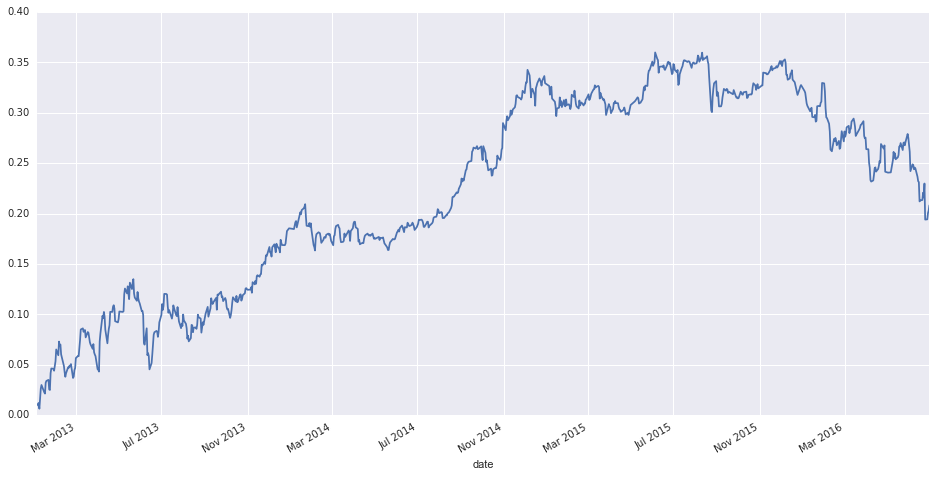

In [320]:
%matplotlib inline
import seaborn

results.groupby('date')['aret_3f'].mean().cumsum().plot( figsize=(16,8) )

<br/><br/><br/><br/>